In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from tensorflow.keras import Input, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from xgboost import XGBClassifier

# Loading Data and SVM Prediction

On this part, the dataset of stroke prediction is loaded and predicted by using SVM Classifier.

SVM Classifier has many hyperparameters such as C, gamma, and kernel. A grid search CV to choose the best hyperparameters is used.

"Balanced" class weight and cross fold validation were used due to the class imbalance nature of the dataset.

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
# Data loading
data = pd.read_csv("/home/zellha/Documents/Dataset/Stroke_Dataset/healthcare-dataset-stroke-data-raw.csv")

print(data.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [14]:
print("Shape:", data.shape)
print("Columns:", data.columns)

Shape: (5110, 12)
Columns: Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [15]:
print(data.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [16]:
# Change N/A in bmi as the average value of bmi
data["bmi"] = data["bmi"].replace("N/A", pd.NA)
data["bmi"] = data["bmi"].astype(float)
data["bmi"] = data["bmi"].fillna(data["bmi"].mean())

In [17]:
# Drop ID column (not needed)
data = data.drop(columns = ["id"])

In [18]:
# One hot encoder for nominal and label encoder for binary
binary_cols = ["ever_married", "Residence_type"]
for col in binary_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

data = pd.get_dummies(data, columns = ["gender", "work_type", "smoking_status"], drop_first = True)

print(data.head())

    age  hypertension  heart_disease  ever_married  Residence_type  \
0  67.0             0              1             1               1   
1  61.0             0              0             1               0   
2  80.0             0              1             1               0   
3  49.0             0              0             1               1   
4  79.0             1              0             1               0   

   avg_glucose_level        bmi  stroke  gender_Male  gender_Other  \
0             228.69  36.600000       1         True         False   
1             202.21  28.893237       1        False         False   
2             105.92  32.500000       1         True         False   
3             171.23  34.400000       1        False         False   
4             174.12  24.000000       1        False         False   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                    False   
1           

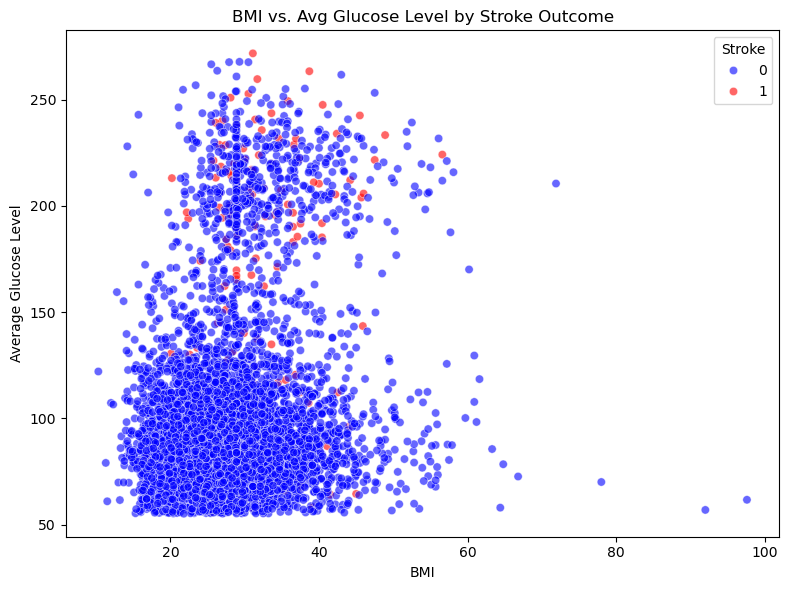

In [19]:
# Scatter plot for stroke according to body mass index and average glucose level
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=data,
    x="bmi",
    y="avg_glucose_level",
    hue="stroke",            # color points by stroke (0 or 1)
    palette={0: "blue", 1: "red"},
    alpha=0.6
)
plt.title("BMI vs. Avg Glucose Level by Stroke Outcome")
plt.xlabel("BMI")
plt.ylabel("Average Glucose Level")
plt.legend(title="Stroke")
plt.tight_layout()
plt.show()


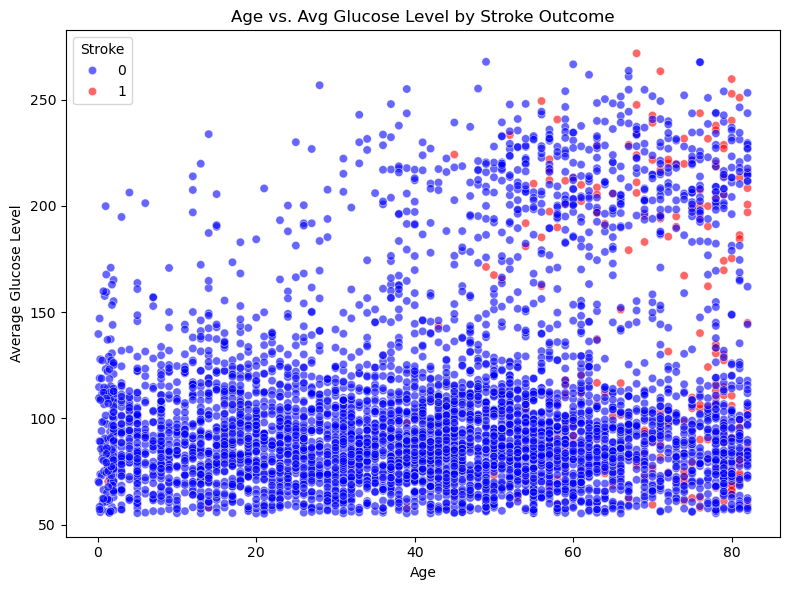

In [20]:
# Scatter plot for stroke according to age and average glucose level
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=data,
    x="age",
    y="avg_glucose_level",
    hue="stroke",            # color points by stroke (0 or 1)
    palette={0: "blue", 1: "red"},
    alpha=0.6
)
plt.title("Age vs. Avg Glucose Level by Stroke Outcome")
plt.xlabel("Age")
plt.ylabel("Average Glucose Level")
plt.legend(title="Stroke")
plt.tight_layout()
plt.show()


In [21]:
# Drop stroke column for learning and add stroke as label
X = data.drop(columns = ["stroke"])
y = data["stroke"]

In [22]:
# Train test split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on training set only to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: stroke
0    3889
1     199
Name: count, dtype: int64
After SMOTE: stroke
0    3889
1    3889
Name: count, dtype: int64


In [23]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Parameter Grid for grid search with 5 cross fold validation
param_grid = {
    "C" : [0.1, 1, 10 ,100],
    "gamma" : [0.001, 0.01, 0.1, 1],
    "kernel" : ["rbf", "poly", "sigmoid"],
    "class_weight" : ["balanced"]
    }

grid_search = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid,
    scoring = "f1",
    cv = 5,
    n_jobs = -1,
    verbose = 2
    )

# SVM classification with param_grid
grid_search.fit(X_train_scaled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
print("Best CV score (F1):", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=poly; total time=   2.4s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.6s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END .C=0.1, class_weight=balanced, gamma=1, kernel=poly; total time=   7.7s
[CV] END C=1, class_weight=balanced, gamma=1, kernel=sigmoid; total time=   1.6s
[CV] END C=10, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END C=10, class_weight=balanced, gamma=0.001, kernel=sigmoid; total time=   1.4s
[CV] END C=10, class_weight=balanced, gamma=0.01, kernel=poly; total time=   1.4s
[CV] END C=10, class_weight=balanced, gamma=0.01, kernel=sigmoid; total time=   1.2s
[CV] END C=10, class_weight=balanced, gamma=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ...C=10, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.5s
[CV] END C=10, class_weight=b

In [15]:
# Prediction and performance
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred): .2f}")
print(classification_report(y_test, y_pred, target_names = ["No Stroke", "Stroke"]))

Accuracy:  0.88
              precision    recall  f1-score   support

   No Stroke       0.95      0.92      0.94       972
      Stroke       0.03      0.04      0.03        50

    accuracy                           0.88      1022
   macro avg       0.49      0.48      0.48      1022
weighted avg       0.90      0.88      0.89      1022



# XGBoost Model

On this part, XGBoost model will be used as it can handle non-linear dataset. We'll compare SVM result with XGBoost.

In [16]:
# Base model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    random_state=42,
)

# Parameter grid
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300, 500],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="f1",  # we want good balance for stroke detection
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [17]:
# Fit grid search
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Best CV F1: 0.9657594281085746


In [18]:
# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)   # default threshold first

print("Default Threshold (0.5):")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

Default Threshold (0.5):
Test Accuracy: 0.9510763209393346
              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97       972
      Stroke       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/home/zellha/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zellha/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zellha/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [19]:
# Find best threshold
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1_scores = np.where((prec + rec) > 0, 2 * (prec * rec) / (prec + rec), 0)
f1_scores = np.nan_to_num(f1_scores, nan=0.0)
best_idx = np.argmax(f1_scores)

best_threshold = thresh[best_idx]

print("Best threshold:", best_threshold)

Best threshold: 8.8042696e-05


/tmp/ipykernel_4370/1921908670.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = np.where((prec + rec) > 0, 2 * (prec * rec) / (prec + rec), 0)


In [20]:
# Apply best threshold
y_pred = (y_proba >= best_threshold).astype(int)

print(f"\nCustom Threshold ({best_threshold:.3f}):")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


Custom Threshold (0.000):
Test Accuracy: 0.9080234833659491
              precision    recall  f1-score   support

   No Stroke       0.96      0.95      0.95       972
      Stroke       0.13      0.16      0.15        50

    accuracy                           0.91      1022
   macro avg       0.54      0.55      0.55      1022
weighted avg       0.92      0.91      0.91      1022



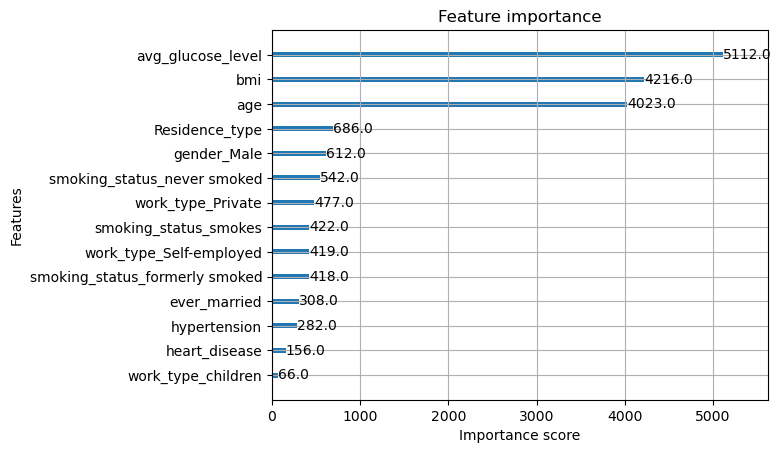

In [21]:
# Main features that causes stroke
xgb.plot_importance(best_xgb, importance_type="weight")
plt.show()

# 4 Hidden Layers Neural Network Model

Neural network theoretically should improve our recall score at the expense of compute power

In [24]:
# Build 4 hidden layers neural networks for prediction
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # define input layer
    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping and LR reduce
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_scaled, y_train_resampled,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, lr_schedule],
    verbose=2
)


I0000 00:00:1757992013.298305    2822 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6095 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/500


I0000 00:00:1757992016.135615    4434 service.cc:148] XLA service 0x7f8eb8002aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757992016.135639    4434 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-09-16 10:06:56.208127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757992016.485850    4434 cuda_dnn.cc:529] Loaded cuDNN version 90201
I0000 00:00:1757992018.639794    4434 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 - 10s - 104ms/step - accuracy: 0.6037 - loss: 0.8440 - precision: 0.4708 - recall: 0.4599 - val_accuracy: 0.5617 - val_loss: 0.8562 - val_precision: 1.0000 - val_recall: 0.5617 - learning_rate: 1.0000e-04
Epoch 2/500
98/98 - 1s - 7ms/step - accuracy: 0.7212 - loss: 0.7280 - precision: 0.6314 - recall: 0.6159 - val_accuracy: 0.7301 - val_loss: 0.7941 - val_precision: 1.0000 - val_recall: 0.7301 - learning_rate: 1.0000e-04
Epoch 3/500
98/98 - 0s - 5ms/step - accuracy: 0.7763 - loss: 0.6598 - precision: 0.6991 - recall: 0.7081 - val_accuracy: 0.8117 - val_loss: 0.7102 - val_precision: 1.0000 - val_recall: 0.8117 - learning_rate: 1.0000e-04
Epoch 4/500
98/98 - 1s - 5ms/step - accuracy: 0.8001 - loss: 0.6116 - precision: 0.7273 - recall: 0.7467 - val_accuracy: 0.8445 - val_loss: 0.6230 - val_precision: 1.0000 - val_recall: 0.8445 - learning_rate: 1.0000e-04
Epoch 5/500
98/98 - 0s - 5ms/step - accuracy: 0.8211 - loss: 0.5806 - precision: 0.7514 - recall: 0.7814 - val_accuracy: 0.8670 -

In [26]:
# Evaluate
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.05).astype(int) # With 0.05 threshold to improve recall
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Accuracy: 0.6888454011741683
              precision    recall  f1-score   support

   No Stroke       0.98      0.69      0.81       972
      Stroke       0.11      0.74      0.19        50

    accuracy                           0.69      1022
   macro avg       0.54      0.71      0.50      1022
weighted avg       0.94      0.69      0.78      1022



In [27]:
# Threshold with precision recall curve
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)

# Compute F1 for each threshold
f1_scores = 2 * (prec * rec) / (prec + rec)
f1_scores = np.nan_to_num(f1_scores, nan=0.0)  # handle division by zero

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresh[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}")

# Use that threshold
y_pred = (y_pred_proba > best_threshold).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

Best threshold: 0.0946, Best F1-score: 0.2154
Test Accuracy: 0.7495107632093934
              precision    recall  f1-score   support

   No Stroke       0.98      0.75      0.85       972
      Stroke       0.12      0.68      0.21        50

    accuracy                           0.75      1022
   macro avg       0.55      0.72      0.53      1022
weighted avg       0.94      0.75      0.82      1022



/tmp/ipykernel_2822/3254777428.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (prec * rec) / (prec + rec)


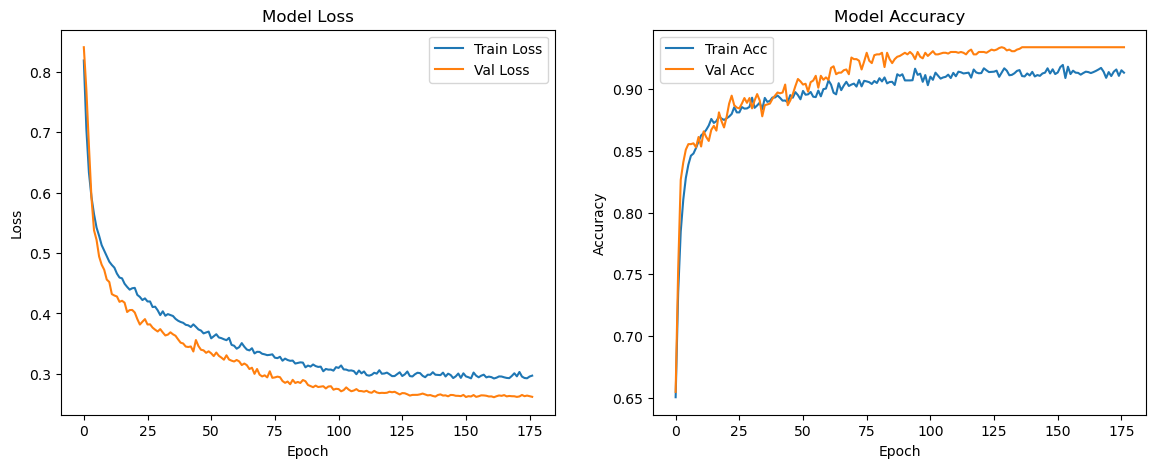

In [25]:
# Plot training & validation loss
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy (or other metrics like Recall/Precision if you want)
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

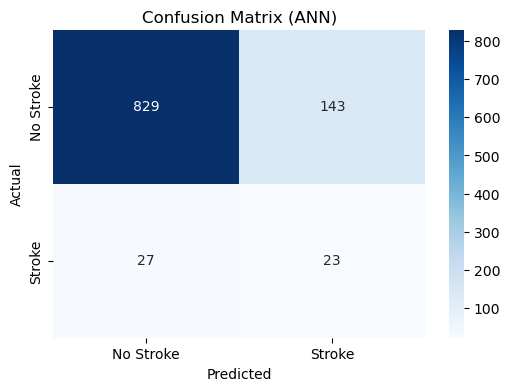

In [26]:
# Confusion matrix with optimized threshold
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (ANN)")
plt.show()

In [28]:
# Rerun with threshold 0.05
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.05).astype(int) # With 0.05 threshold to improve recall
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Accuracy: 0.6888454011741683
              precision    recall  f1-score   support

   No Stroke       0.98      0.69      0.81       972
      Stroke       0.11      0.74      0.19        50

    accuracy                           0.69      1022
   macro avg       0.54      0.71      0.50      1022
weighted avg       0.94      0.69      0.78      1022



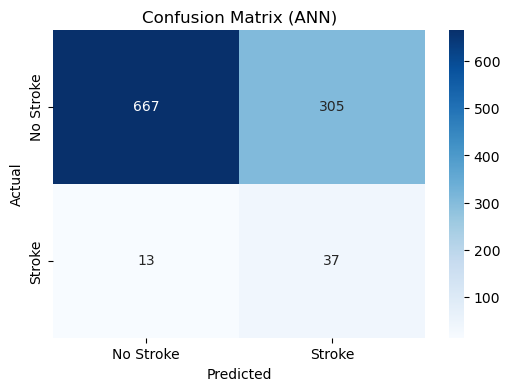

In [29]:
# Confusion matrix with threshold 0.05
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (ANN)")
plt.show()

In [27]:
def predict_patient(model, scaler, patient_data, feature_columns, threshold=0.01):
    """
    Predict stroke risk for a single patient.
    
    Args:
        model: Trained ANN model
        scaler: Fitted scaler (used in training)
        patient_data: dict with human-readable input
        feature_columns: list of all feature names used in training (after encoding)
        threshold: probability threshold for classification
    
    Returns:
        dict with probability and prediction
    """

    # Convert dict to dataframe
    df = pd.DataFrame([patient_data])

    # One-hot encode categorical variables (same as training)
    df_encoded = pd.get_dummies(df)

    # Ensure all training features exist (fill missing with 0)
    for col in feature_columns:
        if col not in df_encoded:
            df_encoded[col] = 0

    # Reorder to match training
    df_encoded = df_encoded[feature_columns]

    # Scale numeric values
    X_scaled = scaler.transform(df_encoded)

    # Predict
    prob = model.predict(X_scaled, verbose=0)[0][0]
    pred = "Stroke" if prob >= threshold else "No Stroke"

    return {"probability": float(prob), "prediction": pred}


In [28]:
feature_columns = [
    "age", "hypertension", "heart_disease", "ever_married", "Residence_type",
    "avg_glucose_level", "bmi",
    "gender_Male", "gender_Other",
    "work_type_Never_worked", "work_type_Private", "work_type_Self-employed", "work_type_children",
    "smoking_status_formerly smoked", "smoking_status_never smoked", "smoking_status_smokes"
]

# Example patient
patient = {
    "age": 24,
    "hypertension": 0,
    "heart_disease": 0,
    "ever_married": 0,       
    "Residence_type": 1,     # (Urban=1, Rural=0)
    "avg_glucose_level": 130,
    "bmi": 22.49,
    "gender_Male": 1, "gender_Other": 0,
    "work_type_Never_worked": 0, "work_type_Private": 1,
    "work_type_Self-employed": 0, "work_type_children": 0,
    "smoking_status_formerly smoked": 0,
    "smoking_status_never smoked": 1,
    "smoking_status_smokes": 0
}

result = predict_patient(model, scaler, patient, feature_columns, threshold=0.01)
print(result)

{'probability': 0.0006781652336940169, 'prediction': 'No Stroke'}
